In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 45.5 MB/s 
     |████████████████████████████████| 188 kB 50.8 MB/s 
     |████████████████████████████████| 60 kB 6.9 MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *

In [3]:
path = '/content/gdrive/MyDrive/images'

In [4]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(224))
dls = dblock.dataloaders(path, bs=64, shuffle=True)

In [5]:
model = xresnet18()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)


Because I have 3 categories, I used less layered architecture (ResNet18) compared to the example on the book which uses Imagenettee dataset, it has 10 categories and it uses ResNet50. Also I used learning rate finder and used suggested learning rate.

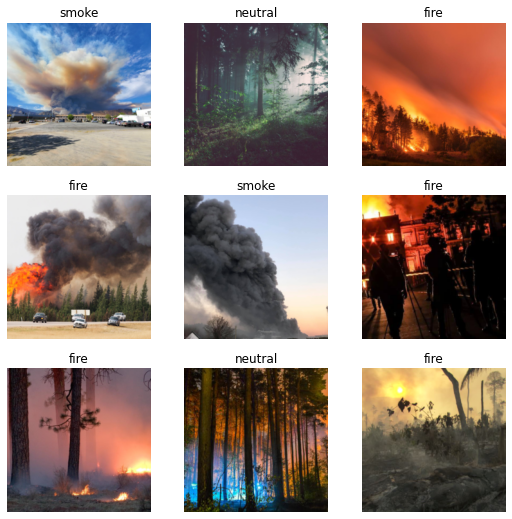

In [50]:
dls.valid.show_batch()

SuggestedLRs(valley=0.0020892962347716093)

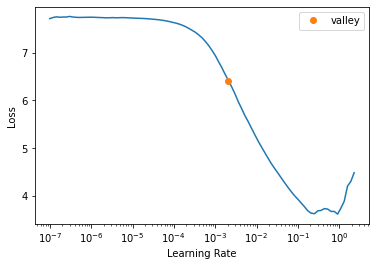

In [6]:
learn.lr_find()

I used the learning rate that learning rate finder suggest.

In [7]:
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.223964,6.556085,0.000000,00:36
1,5.236594,4.088892,0.455556,00:15
2,3.779781,2.626038,0.477778,00:15
3,2.919306,1.685869,0.533333,00:15
4,2.369383,1.011740,0.711111,00:15


This result will be used for comparison with improved models

## Normalization

In [19]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4095, 0.3740, 0.3090], device='cuda:0'),
 TensorImage([0.2807, 0.2692, 0.2812], device='cuda:0'))

The mean and standart deviation along color axises are far from the model's expected values (0 for mean and 1 for standard deviation). Those are the properties of the data which the model is trained with. 

In [8]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(224),
                   batch_tfms=Normalize.from_stats(*imagenet_stats))
dls = dblock.dataloaders(path, bs=64, shuffle=True)

In [9]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.0952, -0.1474, -0.1644], device='cuda:0'),
 TensorImage([1.1602, 1.1354, 1.2744], device='cuda:0'))

After normalization, mean and standart deviation values are close to the expected values.

In [10]:
model = xresnet18()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.315890,6.029431,0.066667,00:15
1,4.395575,1.964821,0.788889,00:15
2,3.175606,1.380487,0.655556,00:16
3,2.426176,0.920336,0.744444,00:15
4,1.956712,0.792792,0.766667,00:15


Although it improved only a little (from 0.711111 to 0.766667), normalization is an important property for pretrained models. The pretrained model only work with the kind of data that is similar to the data which used for training.

## Progressive Resizing

In [25]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(128),
                   batch_tfms=Normalize.from_stats(*imagenet_stats))
dls = dblock.dataloaders(path, bs=128, shuffle=True)

In [26]:
model = xresnet18()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.653897,6.520100,0.000000,00:14
1,5.882299,4.730554,0.400000,00:14
2,4.822752,3.641248,0.633333,00:13
3,4.000710,2.889173,0.744445,00:14
4,3.430622,2.470050,0.755556,00:14


Changing the size of images in the middle of training will change the last layers of our neural network which can be explained as: 
  
  - Model will learn extracting information with convolutional neural network during training with smaller size. 

  - Model will use the convolutional neural network as a pretrained model and adapt that to larger size images to make more accurate predictions. Because of that, we will use **fine_tune()** method when we use the model trained on smaller images as a pretrained model to train larger images.

Training more epochs with smaller images will help the model to  generalize.

SuggestedLRs(valley=0.0012022644514217973)

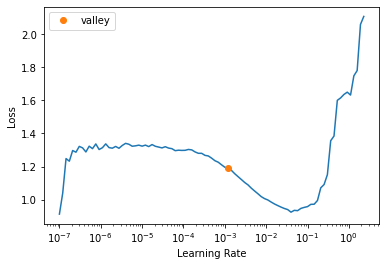

In [27]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(224),
                   batch_tfms=Normalize.from_stats(*imagenet_stats))
learn.dls = dblock.dataloaders(path, bs=64, shuffle=True)

learn.lr_find()

Not to hurt the trained with smaller size images model's parameters, the learning rate for fine tuning should be decreased. I used learning rate finder's suggestion to decrease the learning rate.

In [28]:
learn.fine_tune(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.331232,1.508732,0.766667,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.940576,1.153006,0.811111,00:16
1,0.812146,0.878099,0.777778,00:15
2,0.724986,0.705703,0.788889,00:16


Not to hurt the trained with smaller size images model's parameters, I decreased the learning rate for fine tuning.

After applying Normalization and Progressive Resizing, the accuracy value increased from 0.711111 to 0.788889

## Test Time Augmentation

When we use random cropping in training, fastai will use center cropping for the validation set and this can cause problems to the task we are working. For example, in multilabel classification, cropping an image can cause loosing information. 

Test time augmentation is technique using for validation or inference (Not affect the training). It selects number of areas (4 areas for default) to crop the original image, pass them through the model to make predictions and take the average or maximum of the predictions (average is default).

In [29]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.800000011920929

The learn is a Learner that built on Progressive Resizing part. The last accuracy value that in the training is 0.788889 and after applying tta to validation set, the accuracy value increased. This does not mean the accurracy increased, we calculated the accuracy more fairly.

## Mixup

Mixup is data augmentation technique that provides high accuracy even though we have limited data for training. It mixes existing data with each other by taking their random weighted average. It not only predicts the class of the image, but also predicts the random weights that we used to do augmentation. Because of that, this technique requires much more epochs for training compared to other augmentation techniques to give accurate results.    



In [40]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(224),
                   batch_tfms=Normalize.from_stats(*imagenet_stats))
dls = dblock.dataloaders(path, bs=64, shuffle=True)

In [41]:
model = xresnet18()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(12, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.897963,6.260355,0.000000,00:16
1,6.010238,4.206695,0.777778,00:15
2,4.730357,1.992396,0.700000,00:16
3,3.730107,1.857489,0.444444,00:15
4,3.024580,1.022781,0.622222,00:16
5,2.538513,0.719819,0.744444,00:15
6,2.183314,0.742756,0.744444,00:15
7,1.907503,0.797819,0.711111,00:15
8,1.705740,0.646970,0.766667,00:16
9,1.539329,0.603945,0.766667,00:16


It changes the labels from 1 and 0 to the values between them. This will helps us when calculating loss and updating the weights. Activations that we use in classification are sigmoid and softmax, and outputs of these activations cannot  be 0 or 1. If we force them to give close results to 0 and 1, this will cause overfitting. But with Mixup, our targets would not be strictly 0 or 1 and this wil make updating weights easier and prevent overfitting.

I tried more than one time to train with 15 epochs and I saw that raining much more epoch than 12 could not improve the accurracy. Even so, the accurracy increased from 0.711111 to 0.744444

## Label Smoothing

There is another way to make our target variables further away from 0 and 1 without doing augmentation. This is called** label smoothing**. It actually do not change the labels, it only change the loss function to see our target as close but not equal to 0 and 1.

In [42]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(224),
                   batch_tfms=Normalize.from_stats(*imagenet_stats))
dls = dblock.dataloaders(path, bs=64, shuffle=True)

In [43]:
model = xresnet18()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.574351,6.154769,0.066667,00:16
1,4.817636,3.451427,0.733333,00:16
2,3.744034,2.477112,0.700000,00:16
3,3.128314,1.903844,0.744444,00:15
4,2.737196,1.679806,0.788889,00:16


The accuracy with normalization and label smoothing loss function, increased from 0.711111 to 0.788889

## Conclusion
The best accurracy result compared to other improvement techniques is gotten from Progressive Resizing and Label Smoothing which both uses also Normalization technique. On the other hand, between Mixup and Label Smoothing, Label Smoothing gave better accuracy result.